<a id="head"></a>
# Used Car Price Prediction Project  
### with Data Cleaning, Visualization and Machine Learning      
  
****
  

The dataset is from [Kaggle](https://www.kaggle.com/austinreese/craigslist-carstrucks-data "Kaggle"), collected by [Austin Reese](https://www.kaggle.com/austinreese "austinreese"). which contains more than 500,000 used cars selling records in the US from [craigslist](http://craigslist.org/ "craigslist").

The goal of this project is to explore the dataset and discuss some interesting observations through visualizations and train machine learning models to fit and predict the prices of the used cars using supervised learning.  

It is also a great dataset to practice my data cleaning and transformation skills, as there are many natural problems to solve before analysis in the dataset, such as outliers, null values, categorical features and imbalanced features. As part of the project, we need to clean the data to make it easier to use.

## Table of Contents
1. [Import necessary libraries](#1)<br><br>
2. [Read dataset and first glance](#2)<br><br>
3. [Data cleaning](#3)
  - [Outliers](#3.1)
  - [Uncorrelated columns](#3.2)
  - [Filling null values](#3.3)
  - [Remove samples based on common sense](#3.4)
  - [Remove insufficient records](#3.5)<br><br>
4. [Data visualization](#4)<br><br>
5. [Model preparation](#5)
  - [Encoding categorical features](#5.1)
  - [Normalization](#5.2)
  - [Split training and testing set](#5.3)<br><br>
6. [Models and tuning](#6)
  - [Linear regression](#6.1)
  - [Lasso regression](#6.2)
  - [Multi-layer perceptron](#6.3)
  - [K-NearestNeighbor](#6.4)
  - [Decision tree](#6.5)
  - [Random forest](#6.6)
  - [Support vector machine](#6.7)
  - [Gradient Boosting Decision Tree](#6.8)
  - [XGBoost](#6.9)<br><br>
7. [Evaluate and conclude](#7)<br><br>

<a id="1"></a>
### 1. Import necessary libraries:
[Back to top](#head)

In [1]:
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
import pickle
from joblib import dump, load

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from tensorflow.keras import Sequential, callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Dropout, Activation

pd.set_option('display.max_rows',30)
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\ls\Anaconda3\envs\tensor20\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


<a id="2"></a>
## 2. Read dataset and first glance
[back to top](#head)

In [2]:
df = pd.read_csv('vehicles.csv')

In [3]:
df.describe()

,id,price,year,odometer,county,lat,long
count,5.397590e+05,5.397590e+05,538772.000000,4.407830e+05,0.0,530785.000000,530785.000000
mean,7.087609e+09,1.954214e+05,2009.830982,1.008008e+05,NaN,38.432128,-94.040501
std,5.234176e+06,2.208252e+07,9.161334,1.767058e+05,NaN,5.916936,17.626658
min,7.065765e+09,0.000000e+00,0.000000,0.000000e+00,NaN,-84.911400,-176.810000
25%,7.084240e+09,4.400000e+03,2007.000000,4.703850e+04,NaN,34.197100,-106.782000
50%,7.088973e+09,9.500000e+03,2012.000000,9.330000e+04,NaN,39.077600,-88.100900
75%,7.092094e+09,1.792600e+04,2015.000000,1.377550e+05,NaN,42.449100,-81.219000
max,7.093537e+09,4.294967e+09,2021.000000,6.480922e+07,NaN,84.514800,161.016000


From this basic statistical infomation of the dataset, we can find that:
1. There are about **540,000** samples in the dataset.
2. There are **"free cars"** in the dataset, whose prices are 0. These samples should be removed.
3. The maximal price is **4 billion**. it is an outlier, no matter it is real or not.
4. The minimal year is **0**, which is a value with error.
5. The maximal odometer read is $6.4*10^7$ miles, which should also be an outlier.
6. "county" is a total **empty column**.

We will talk about the remaining categorical features in the next section. Nevertheless, according to our finding above, this dataset **must be cleaned** before we start applying any analysis on it.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539759 entries, 0 to 539758
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            539759 non-null  int64  
 1   url           539759 non-null  object 
 2   region        539759 non-null  object 
 3   region_url    539759 non-null  object 
 4   price         539759 non-null  int64  
 5   year          538772 non-null  float64
 6   manufacturer  516175 non-null  object 
 7   model         531746 non-null  object 
 8   condition     303707 non-null  object 
 9   cylinders     321264 non-null  object 
 10  fuel          536366 non-null  object 
 11  odometer      440783 non-null  float64
 12  title_status  536819 non-null  object 
 13  transmission  535786 non-null  object 
 14  vin           315349 non-null  object 
 15  drive         383987 non-null  object 
 16  size          168550 non-null  object 
 17  type          392290 non-null  object 
 18  pain

There are also a lot of **missing values** among features.

In [5]:
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7088746062,https://greensboro.craigslist.org/ctd/d/cary-2...,greensboro,https://greensboro.craigslist.org,10299,2012.0,acura,tl,NaN,NaN,...,NaN,NaN,other,blue,https://images.craigslist.org/01414_3LIXs9EO33...,2012 Acura TL Base 4dr Sedan Offered by: B...,NaN,nc,35.7636,-78.7443
1,7088745301,https://greensboro.craigslist.org/ctd/d/bmw-3-...,greensboro,https://greensboro.craigslist.org,0,2011.0,bmw,335,NaN,6 cylinders,...,rwd,NaN,convertible,blue,https://images.craigslist.org/00S0S_1kTatLGLxB...,BMW 3 Series 335i Convertible Navigation Dakot...,NaN,nc,NaN,NaN
2,7088744126,https://greensboro.craigslist.org/cto/d/greens...,greensboro,https://greensboro.craigslist.org,9500,2011.0,jaguar,xf,excellent,NaN,...,NaN,NaN,NaN,blue,https://images.craigslist.org/00505_f22HGItCRp...,2011 jaguar XF premium - estate sale. Retired ...,NaN,nc,36.1032,-79.8794
3,7088743681,https://greensboro.craigslist.org/ctd/d/cary-2...,greensboro,https://greensboro.craigslist.org,3995,2004.0,honda,element,NaN,NaN,...,fwd,NaN,SUV,orange,https://images.craigslist.org/00E0E_eAUnhFF86M...,2004 Honda Element LX 4dr SUV Offered by: ...,NaN,nc,35.7636,-78.7443
4,7074612539,https://lincoln.craigslist.org/ctd/d/gretna-20...,lincoln,https://lincoln.craigslist.org,41988,2016.0,chevrolet,silverado k2500hd,NaN,NaN,...,NaN,NaN,NaN,NaN,https://images.craigslist.org/00S0S_8msT7RQquO...,"Shop Indoors, Heated Showroom!!!www.gretnaauto...",NaN,ne,41.1345,-96.2458


Many columns have **nothing to do with the prices of the car**, such as "id", "url", "image_url". We will remove columns like this in the next section.

<a id="3"></a>
## 3. Data Cleaning
[Back to top](#head)

<a id="3.1"></a>
### 3.1 Outliers

Fist we need to remove the outliers of the **prices**. See the output from df.describe(), the price range between 25% to 75% quantile of our dataset is 4400 ~ 17926, but the maximum price is 4.3*10^9, which is too high for a price!

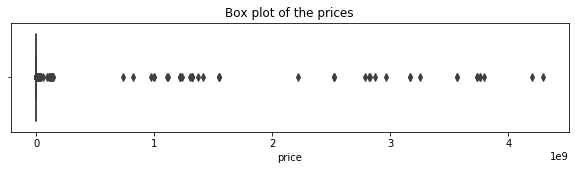

In [6]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_title('Box plot of the prices')
sns.boxplot(x='price', data = df)

There indeed are **some extremely large prices** in our box plot. They are too large for us to actually see the "box". We have to remove them. The common way to remove the outliers is using **interquartile range** showing below.

In [7]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
filter = (df['price'] >= Q1 - 1.5 * IQR) & (df['price'] <= Q3 + 1.5 *IQR)
init_size = df.count()['id']
df = df.loc[filter]  
filtered_size = df.count()['id']
print(init_size-filtered_size,'(', '{:.2f}'.format(100*(init_size-filtered_size)/init_size), '%',')', 'outliers removed from dataset')

17156 ( 3.18 % ) outliers removed from dataset


With 3% data loss, we now get a much better distribution of prices.

But when we draw the distribution plot of the prices:

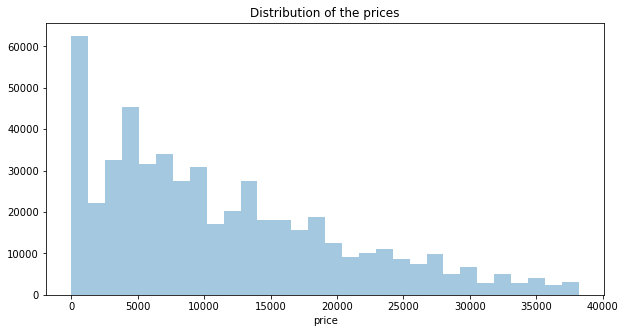

In [8]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Distribution of the prices')
sns.distplot(df['price'], bins=30, kde=False)

We can see that there are a large amount of wierd "free cars" in our dataset. We have to remove them as well.

Here we set a threshhold of **$600**. 

In [9]:
df = df[df['price']>600]

Now let's see whether there are outliers to remove in the **odometer column**.

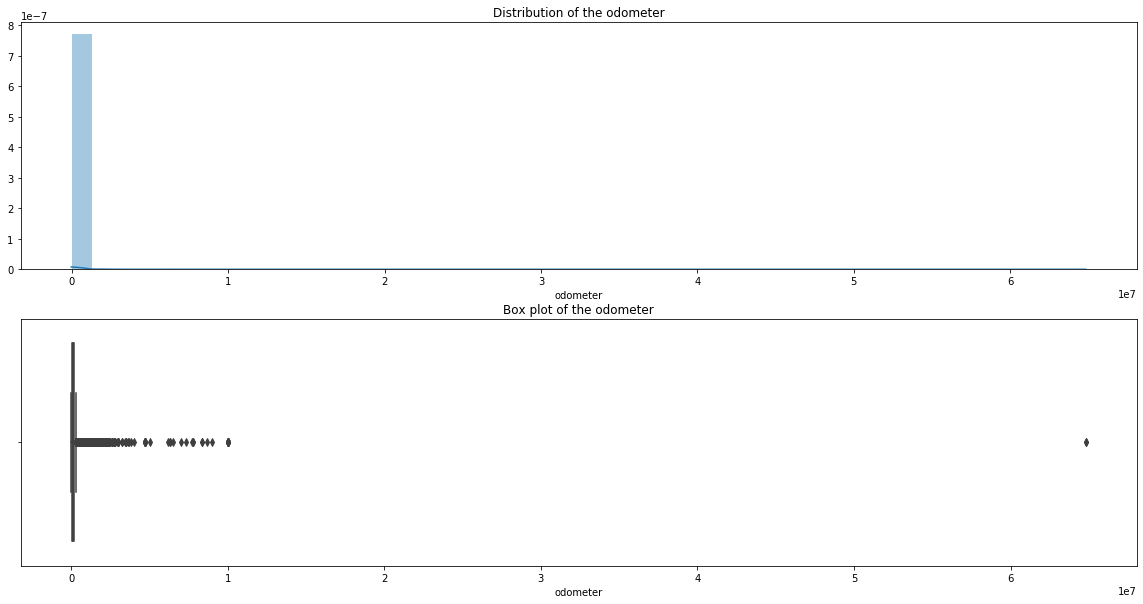

In [10]:
fig, axs = plt.subplots(2, figsize=(20,10))
sns.distplot(df['odometer'], ax = axs[0])
axs[0].set_title('Distribution of the odometer')
axs[1].set_title('Box plot of the odometer')
sns.boxplot(x='odometer', data = df, ax=axs[1])

Same problem happens to the odometer column. The outliers could come from two situations:

1. **Mistakes in the samples** (such as the sample larger than 6*10^7 miles)
2. Most of the used cars have relatively low mileage, which **lower the median**, while some other cars actally run that far.

However, both situations cause uncertainty to the prediction of our future model, thus we remove these outliers using the same method as above. The only differece is our filter:

1. **Extremly small odoemter is OK** to keep, as they tend to be new cars.
2. The upper threshold is set to be higher, accepting more samples.

In [11]:
Q1 = df['odometer'].quantile(0.25)
Q3 = df['odometer'].quantile(0.75)
IQR = Q3 - Q1
filter = (df['odometer'] <= Q3 + 3 *IQR)
init_size = df.count()['id']
df = df.loc[filter]  
filtered_size = df.count()['id']
print(init_size-filtered_size,'(', '{:.2f}'.format(100*(init_size-filtered_size)/init_size), '%',')', 'outliers removed from dataset')

83864 ( 17.95 % ) outliers removed from dataset


Although we give up **18%** of our data, the odometer column now should look normal.

<a id="3.2"></a>
### 3.2 Uncorrelated columns

Next we need to drop some uncorrelated columns. They are columns that we are pretty sure having no correlations to the car prices. This include the **id, url, region, region_url, title_status, VIN, image_url, description, county** (as it is an empty column). As for its **state and cordinate**, we need to make sure they don't have high correlation to the price.

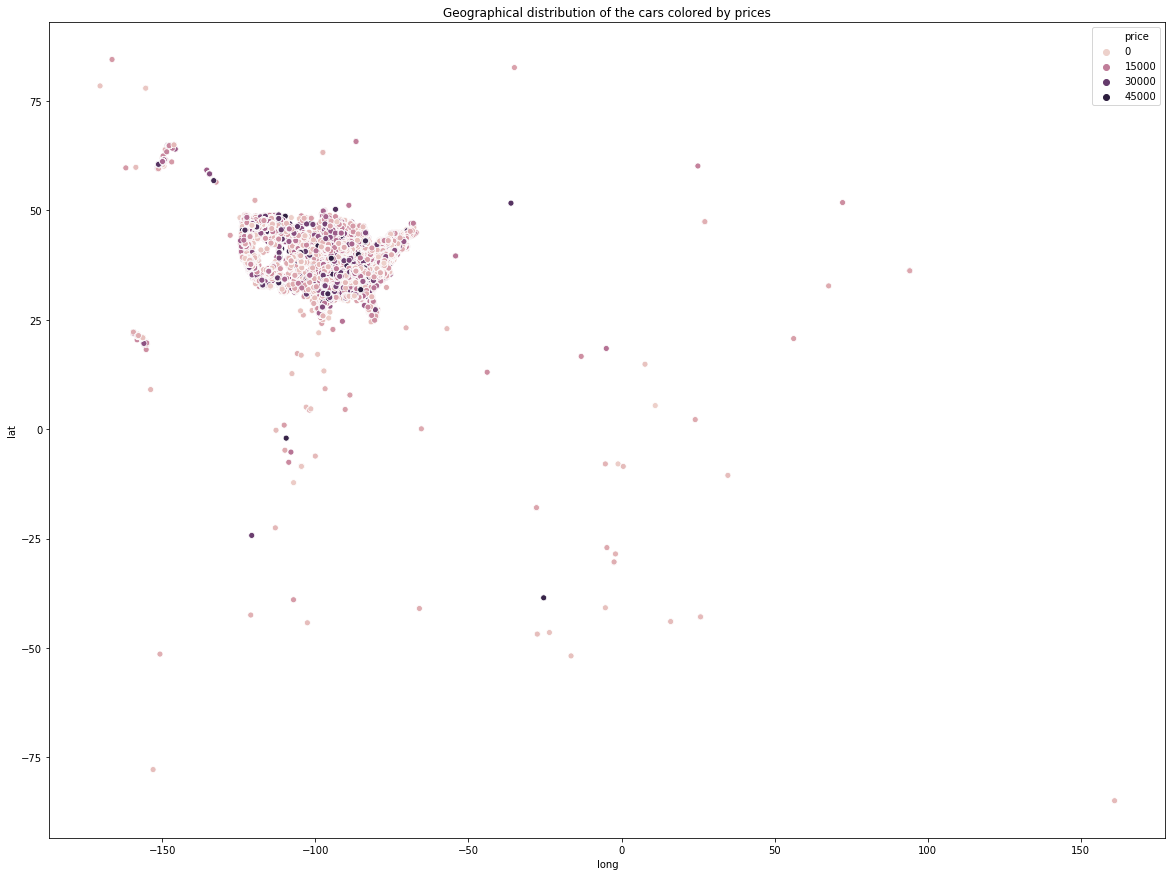

In [12]:
fig, ax = plt.subplots(figsize=(20,15))
ax.set_title('Geographical distribution of the cars colored by prices')
sns.scatterplot(x= 'long', y='lat', data = df, hue = 'price', ax=ax )

We can see that **most of the used cars are being sold in the US**, some others are in other parts of the world. Although the high price cars are not seperated uniformly, **the prices don't seem to vary much geographically**, indicating that there are not significant correlations between prices and coordinates.

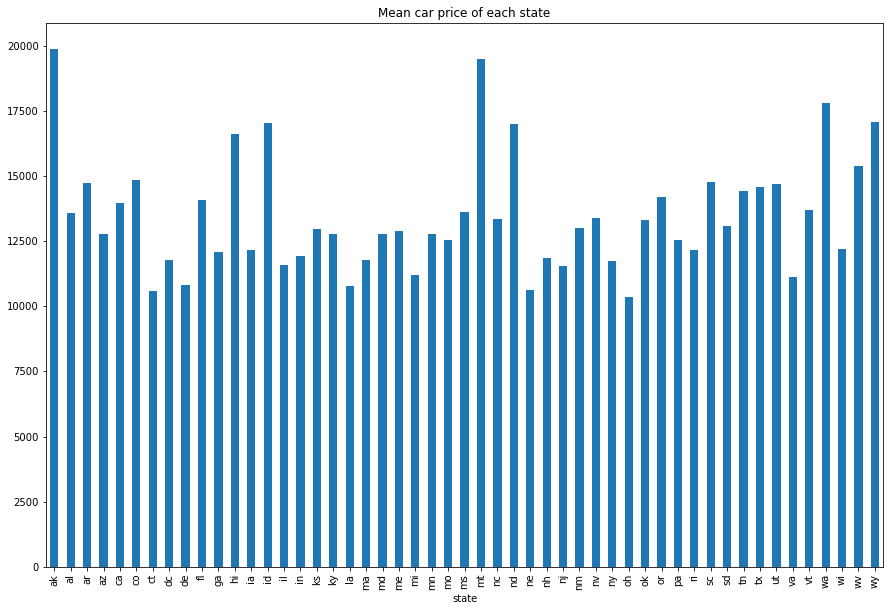

In [13]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Mean car price of each state')
df.groupby(['state']).mean()['price'].plot.bar(ax=ax)

<img src="./IMG/Capture.PNG"
     alt="Mean price in states"
     />

The prices **don't differ very much in each states** in the US either. But we do find that **the used car prices are slightly higher in the states neighboured on Canada** (such as Alaska, Idaho, Washington, Montana, North Dakota). See the figure above, where **<font color=#6495ED>blue</font> indicates higher average prices**, while **<font color=#DAA520>yellow</font> indicates lower average prices**. The second figure is drawn in Power BI.

As locations do not have major correlation to the prices, we choose to **remove 'long', 'lat' and 'state'** as well.

In [14]:
df = df.drop(columns = ['id', 'url', 'region', 'region_url', 'title_status', 'vin', 'image_url', 'description', 'county', 'state', 'long', 'lat'])


In [15]:
df.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color
0,10299,2012.0,acura,tl,NaN,NaN,gas,90186.0,automatic,NaN,NaN,other,blue
2,9500,2011.0,jaguar,xf,excellent,NaN,gas,85000.0,automatic,NaN,NaN,NaN,blue
3,3995,2004.0,honda,element,NaN,NaN,gas,212526.0,automatic,fwd,NaN,SUV,orange
5,12995,2015.0,kia,sportage,NaN,NaN,gas,85127.0,automatic,4wd,NaN,wagon,NaN
6,10995,2014.0,chevrolet,traverse,NaN,NaN,gas,112383.0,automatic,fwd,NaN,SUV,black


Now the feature columns are all we believe **correlated to the prices**.

<a id="3.3"></a>
### 3.3 Filling null values

Now that we have column 'model', there is no need for the column 'manufacturer' for modeling (as normally one car model only belongs to one manufacturer). But as it is still needed for further visualization, we store this column into a new data frame (**df_man**) before removing it.

In [16]:
df_man = df['manufacturer'].to_frame()

In [17]:
df = df.drop(columns = ['manufacturer'])

Now let's check the distribution of the null values among all columns.

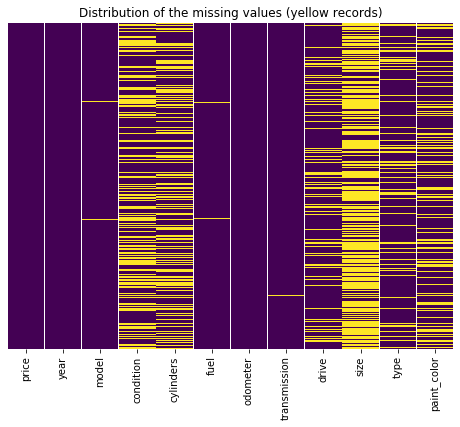

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_title('Distribution of the missing values (yellow records)')
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Based on the situation that there are plenty of null values in our dataset, and the fact that these missing values are **hard to fill with proper guesses**. we decide to take the following three actions:
1. For columns that have **too much** missing values, we **remove the whole column**. (for column "size")
2. For columns that have **very few** missing values, we **remove the corresponding rows**. (for column "year", "manufacturer", "model", "fuel", "transmission", "drive", "type", "paint_color")
3. For columns that have **intermediate number of missing values**, such as "condition" and "cylinders", we choose to **keep the missing values and assign them another unique category called "null"**. 

In [19]:
df = df.drop(columns = ['size'])

In [20]:
rm_rows = ['year', 'model', 'fuel', 'transmission', 'drive', 'type', 'paint_color']
for column in rm_rows:
    df = df[~df[column].isnull()]

In [21]:
df = df.replace(np.nan, 'null', regex=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224870 entries, 3 to 539757
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         224870 non-null  int64  
 1   year          224870 non-null  float64
 2   model         224870 non-null  object 
 3   condition     224870 non-null  object 
 4   cylinders     224870 non-null  object 
 5   fuel          224870 non-null  object 
 6   odometer      224870 non-null  float64
 7   transmission  224870 non-null  object 
 8   drive         224870 non-null  object 
 9   type          224870 non-null  object 
 10  paint_color   224870 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 20.6+ MB


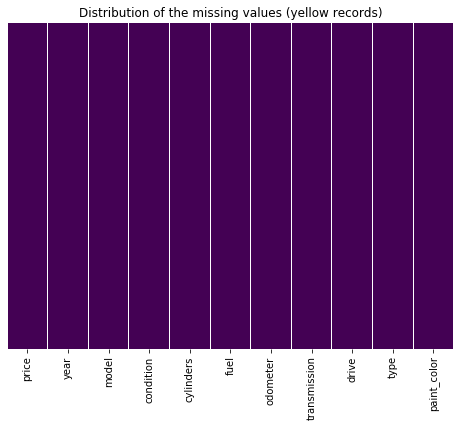

In [22]:
df.info()
fig, ax = plt.subplots(figsize=(8,6))
ax.set_title('Distribution of the missing values (yellow records)')
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Now there is **no missing values** in our dataset.

<a id="3.4"></a>
### 3.4 Remove samples based on common sense

Let's first see the relationship between **prices** and **mileages (odometer)**.

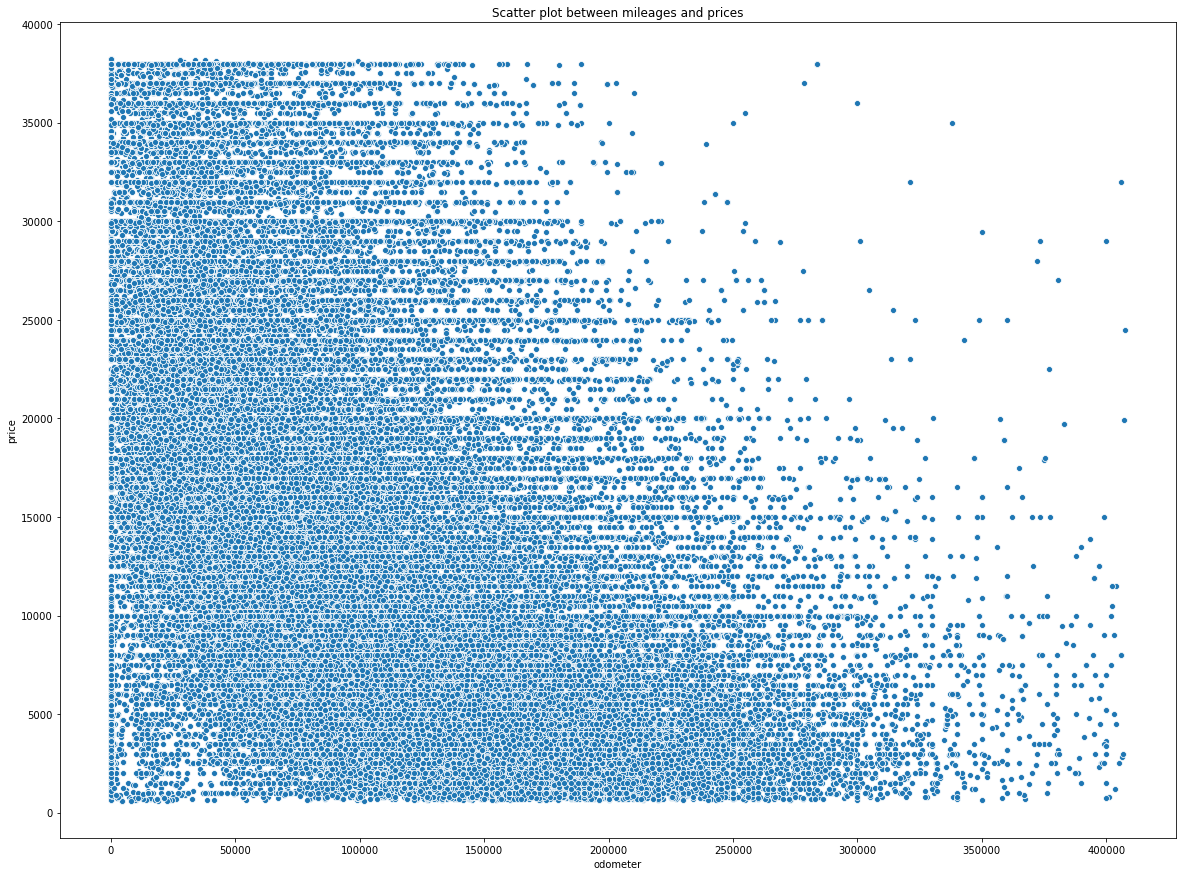

In [23]:
fig, ax = plt.subplots(figsize=(20,15))
ax.set_title('Scatter plot between mileages and prices')
sns.scatterplot(x='odometer', y='price', data=df)

**Higher odometer tends to have lower prices**, while lower odometer tends to be more expensive. Also, a funny observation is that people tend to set their prices easy to remember such as 5000, 5100, 8999 (there are **many horizontal straight lines** in the scatter plot above).

However, there are some **relatively new cars were sold nearly for free**, which is against common sense. Thus we need to do some intervention to it.

In [24]:
df = df[(df['price']+df['odometer'])>5000]

Cars that are too old (let's say **earier than 1960**) will increase uncertainty to our data prediction, because of the insufficient amount and probably unstable prices (some of them can be regarded as antiques). So we remove the samples **older than 1960**.

In [25]:
df = df[df['year']>1960]

<a id="3.5"></a>
### 3.5 Remove insufficient records

In [26]:
df_man['manufacturer'].value_counts()

ford            68745
chevrolet       55182
toyota          30414
nissan          21291
honda           19543
                ...  
datsun             33
land rover         16
porche              9
aston-martin        3
ferrari             1
Name: manufacturer, Length: 41, dtype: int64

Some brands have **too few samples**.

We remove the manufacturers which hold **less than 100 records**.

In [27]:
rm_brands = ['harley-davidson', 'alfa-romeo', 'datsun', 'tesla', 'land rover', 'porche', 'aston-martin', 'ferrari']
for brand in rm_brands:
    df_man = df_man[~(df_man['manufacturer'] == brand)]

Now let's head to the car models. For the precision of our future model, we choose to remove the **car models which have less than 50 samples**. It will narrow the capability of our model, but in return lower the bias and variance.

In [28]:
df = df.groupby('model').filter(lambda x: len(x) > 50)

In [29]:
df['model'].value_counts()

f-150                   5471
silverado 1500          3324
1500                    3065
silverado               2310
wrangler                1997
                        ... 
rl                        51
outback 2.5i premium      51
sebring convertible       51
mirage                    51
rsx                       51
Name: model, Length: 662, dtype: int64

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150512 entries, 3 to 539757
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         150512 non-null  int64  
 1   year          150512 non-null  float64
 2   model         150512 non-null  object 
 3   condition     150512 non-null  object 
 4   cylinders     150512 non-null  object 
 5   fuel          150512 non-null  object 
 6   odometer      150512 non-null  float64
 7   transmission  150512 non-null  object 
 8   drive         150512 non-null  object 
 9   type          150512 non-null  object 
 10  paint_color   150512 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 13.8+ MB


<a id="4"></a>
## 4. Data visualization
[Back to top](#head)

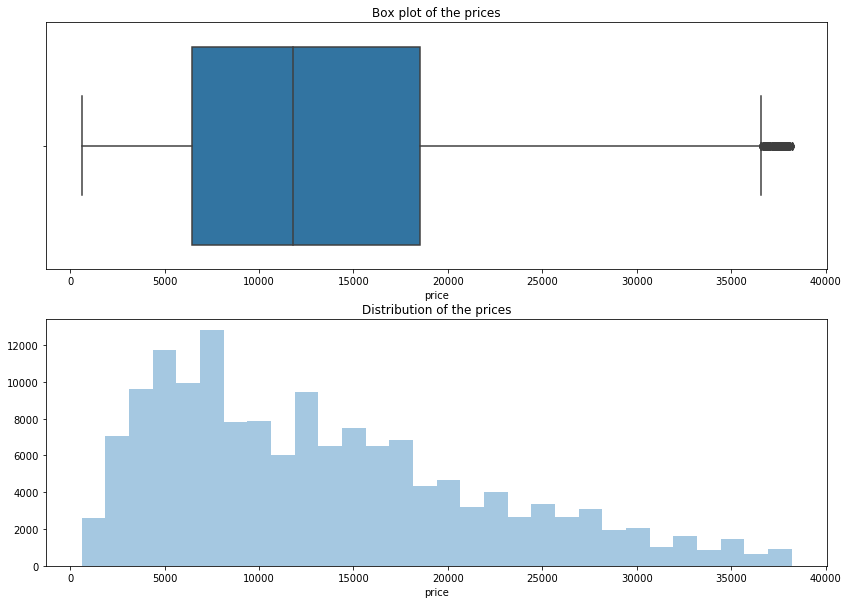

In [31]:
fig, axs = plt.subplots(2, figsize=(14, 10))
axs[0].set_title('Box plot of the prices')
sns.boxplot(x='price', data = df, ax = axs[0])
axs[1].set_title('Distribution of the prices')
sns.distplot(df['price'], ax=axs[1], bins=30, kde=False)

We see that after the data cleaning, the distribution of the prices looks better. Most of the cars are sold in price between  

Text(0.5, 1.0, 'Distribution of the odometer')

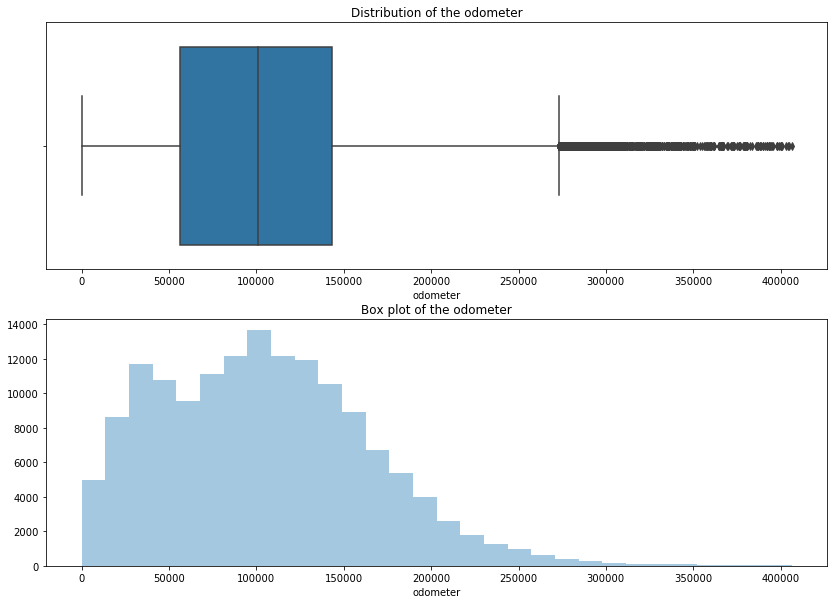

In [32]:
fig, axs = plt.subplots(2, figsize=(14, 10))
sns.distplot(df['odometer'], ax = axs[1], bins=30, kde=False)
axs[1].set_title('Box plot of the odometer')
sns.boxplot(x='odometer', data = df, ax=axs[0])
axs[0].set_title('Distribution of the odometer')

Now let's see how differnt factors influence the car prices

In [33]:
df['paint_color'].value_counts()

white     36385
black     29890
silver    23091
grey      15812
blue      15614
red       15225
custom     5002
green      3854
brown      3474
orange      964
yellow      869
purple      332
Name: paint_color, dtype: int64

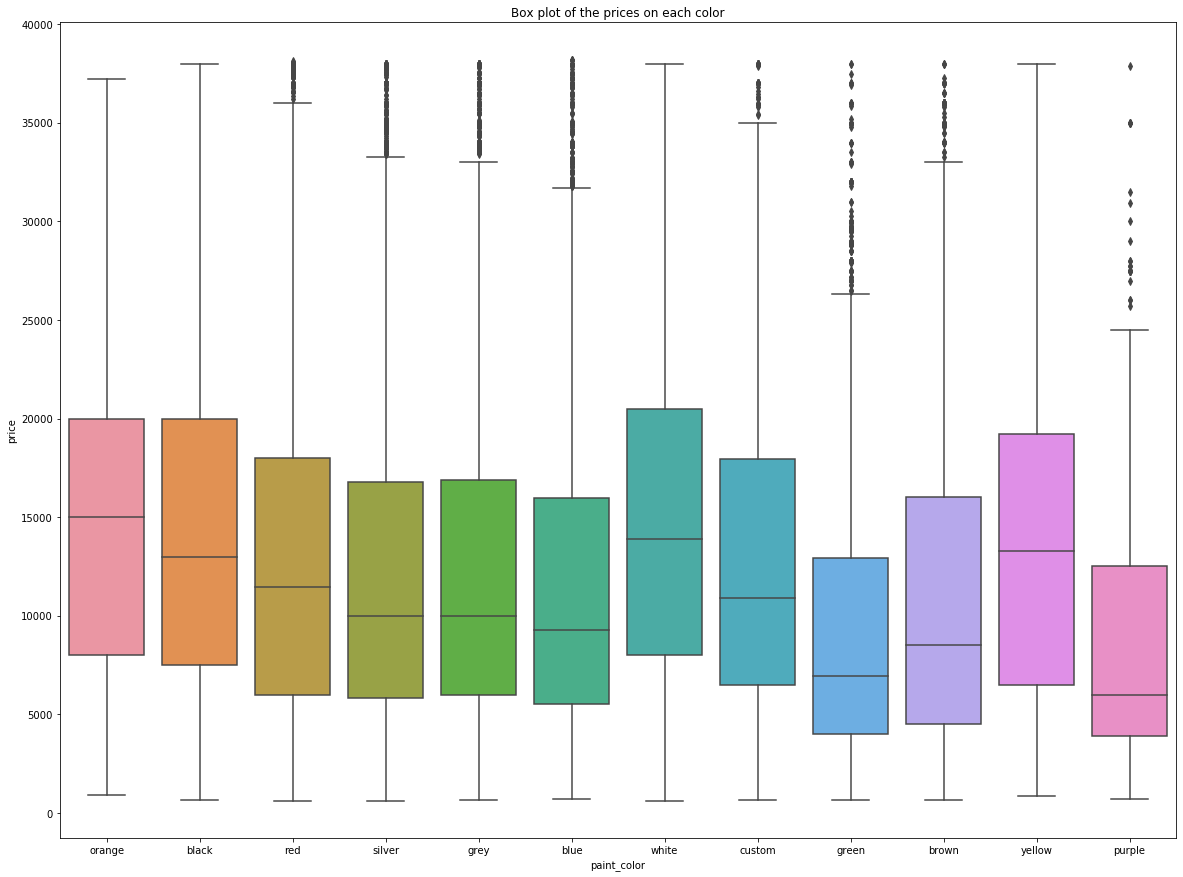

In [34]:
fig, ax = plt.subplots(figsize=(20,15))
ax.set_title('Box plot of the prices on each color')
sns.boxplot(x='paint_color', y='price', data = df)

Besides customized colors, there are **11** different common colors in the dataset. It seems that **white, black, orange and yellow** cars are the top 4 colors ranked by their median prices. By contrast, **green and purple** are the least welcome colors. Note that due to relatively fewer samples for purple, yellow and orange, the statement above may not totally correct. 

SUV            38768
sedan          38434
pickup         21846
truck          20551
coupe           7541
wagon           5105
hatchback       4802
other           4307
van             3841
mini-van        2875
convertible     2050
offroad          328
bus               64
Name: type, dtype: int64


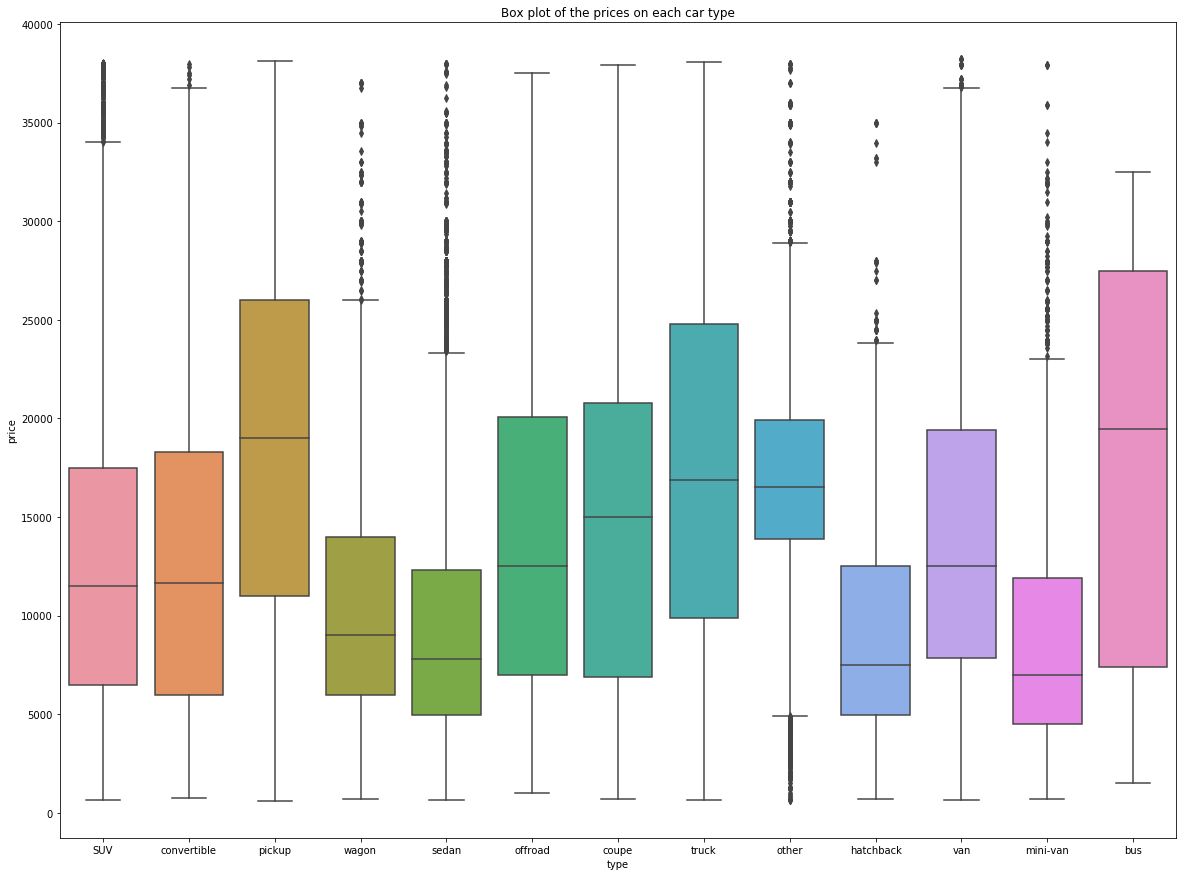

In [35]:
print(df['type'].value_counts())
fig, ax = plt.subplots(figsize=(20,15))
ax.set_title('Box plot of the prices on each car type')
sns.boxplot(x='type', y='price', data = df)

**Pickup cars, trucks and buses have higher prices** as they cost higher for new. The prices for **sedan, wagon, hatchback and mini-van are more stable**.

In [36]:
print('Condition:')
print(df['condition'].value_counts())
print('\nCylinders:')
print(df['cylinders'].value_counts())
print('\nFuel:')
print(df['fuel'].value_counts())
print('\nTransmission:')
print(df['transmission'].value_counts())
print('\nDrive:')
print(df['drive'].value_counts())

fig=plt.figure(figsize=(25,37))
fig.add_subplot(3, 2, 1)
 
sns.boxplot(x='condition', y='price', data = df)
fig.add_subplot(3, 2, 2)
sns.boxplot(x='cylinders', y='price', data = df)
fig.add_subplot(3, 2, 3)
sns.boxplot(x='fuel', y='price', data = df)
fig.add_subplot(3, 2, 4)
sns.boxplot(x='transmission', y='price', data = df)
fig.add_subplot(3, 2, 5)
sns.boxplot(x='drive', y='price', data = df)

Condition:
excellent    48573
null         45694
good         44318
like new      8955
fair          2578
new            208
salvage        186
Name: condition, dtype: int64

Cylinders:
6 cylinders     41413
4 cylinders     39390
8 cylinders     34258
null            33570
5 cylinders       993
10 cylinders      542
other             189
3 cylinders       151
12 cylinders        6
Name: cylinders, dtype: int64

Fuel:
gas         135546
diesel        9584
other         4028
hybrid        1189
electric       165
Name: fuel, dtype: int64

Transmission:
automatic    135384
manual         7622
other          7506
Name: transmission, dtype: int64

Drive:
4wd    66665
fwd    58155
rwd    25692
Name: drive, dtype: int64


Error in callback <function flush_figures at 0x000001DC8DF648C8> (for post_execute):


KeyboardInterrupt: 

From these five figures we conclude the following reasonable phenomena:
- New and like-new cars tend to be more expensive, while cars with fair and salvage conditions tend to be much cheaper. 
- Cars with 6, 8 or 10 cylinders tend to be more expensive,  while 4 and 5-cylinder cars are cheaper.
- Diesel cars are more expensive than gas and hybrid cars.
- Cars with "other" transmission (possibly CVT) tend to be the most expensive. Cars with automatic transmission tend to be more expensive than those with manual transmission.
- Cars equipped with all-wheel drive tend to be more expensive than those with front-wheel drive.

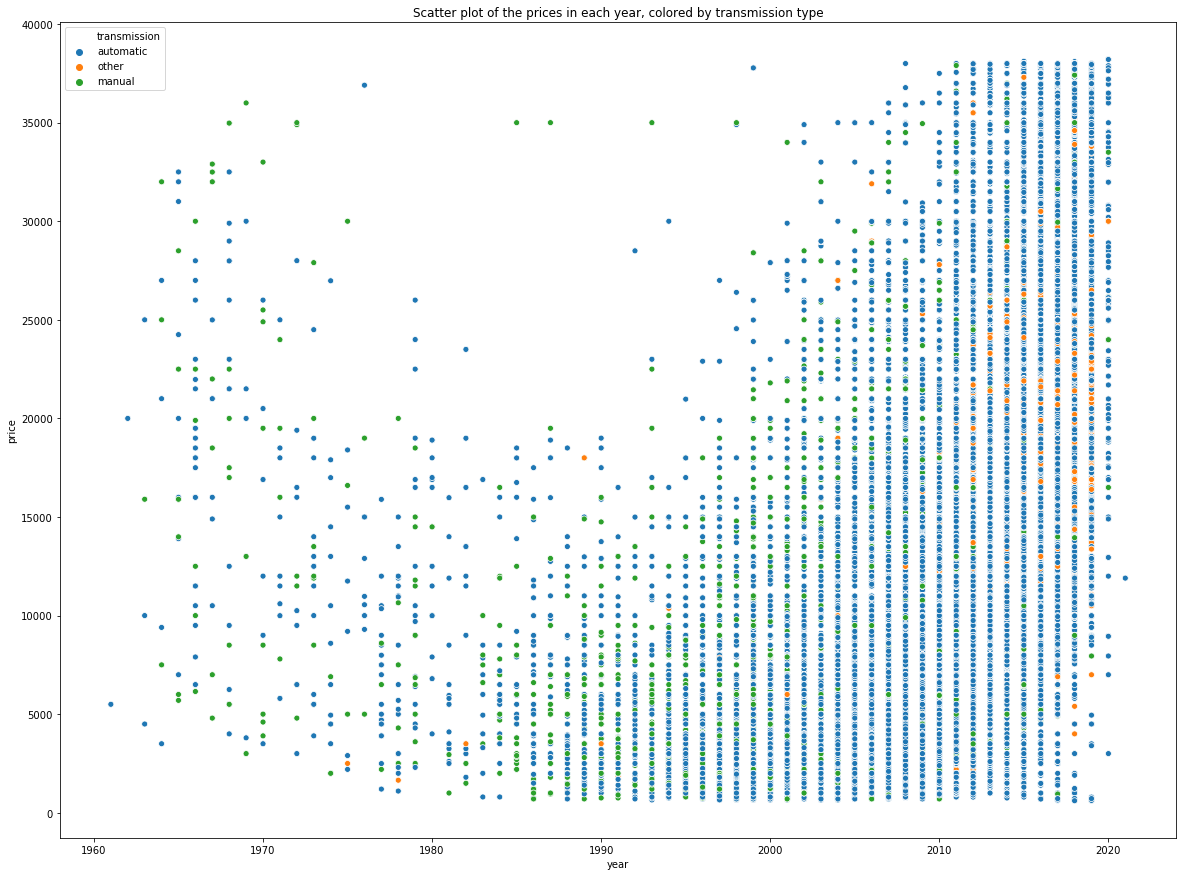

In [37]:
fig, ax = plt.subplots(figsize=(20,15))
ax.set_title('Scatter plot of the prices in each year, colored by transmission type')
#sns.scatterplot(x='year', y='price', data=df[(df['transmission'] =='manual') | (df['transmission'] =='other')], hue = 'transmission')
sns.scatterplot(x='year', y='price', data=df, hue = 'transmission')

**Higher prices are more likely to be seen in newer cars**. Older cars tend to be cheaper (but not always).

Although there are more and more cars with automatic transmission, manual types are still very poplular. Also, there appears to be **more cars with "other" transimission since 2010**. I guess they include new type gearboxes such as **CVT** and DCT.

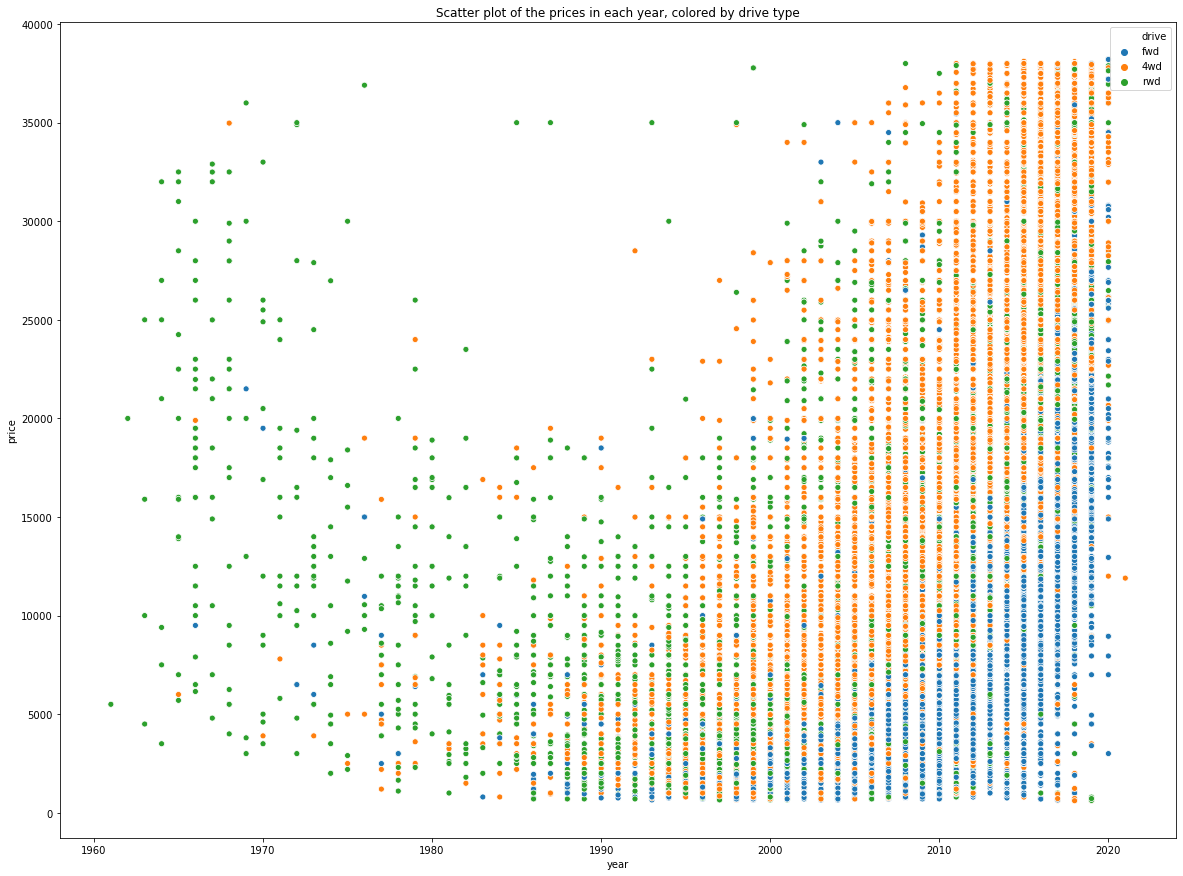

In [38]:
fig, ax = plt.subplots(figsize=(20,15))
ax.set_title('Scatter plot of the prices in each year, colored by drive type')
sns.scatterplot(x='year', y='price', data=df, hue = 'drive')

We see that **most of the old cars (older than 1990) are rear wheel drive**. **Front wheel drive and all wheel drive started to get popular since 1990**. **Cars with AWD are obviously more expensive than cars with FWD**, which is quite reasonable. There are still some expensive cars with RWD, I guess it is because RWD are equipped by many sports car nowadays.  

In [39]:
fig, ax = plt.subplots(figsize=(20,15))
ax.set_title('Scatter plot of the prices in each year, colored by fuel type')
sns.scatterplot(x='year', y='price', data=df, hue = 'fuel')

Error in callback <function flush_figures at 0x000001DC8DF648C8> (for post_execute):


KeyboardInterrupt: 

It is obvious to see that **diesel cars tend to be more expensive than gas cars**. One of the main reason could be diesel engines are usually more expensive and are **mostly equipped by high power vehicles such as trucks, buses and upmarket SUVs**. A strange phenomenon is that although diesel engines appear far earlier than gas engines, **we can hardly see them in the used cars older than 1990**. 

In [40]:
fig, ax = plt.subplots(figsize=(20,15))
ax.set_title('Scatter plot of the prices in each year, colored by cylinder type')
sns.scatterplot(x='year', y='price', data=df, hue = 'cylinders')

Error in callback <function flush_figures at 0x000001DC8DF648C8> (for post_execute):


KeyboardInterrupt: 

We can see that **most of the cars have 8 cylinders before 1990**. In recent years, **upmarket is occupied by 6 and 8-cylinder cars** and **relatively cheap cars are mainly 4-cylinder type**.

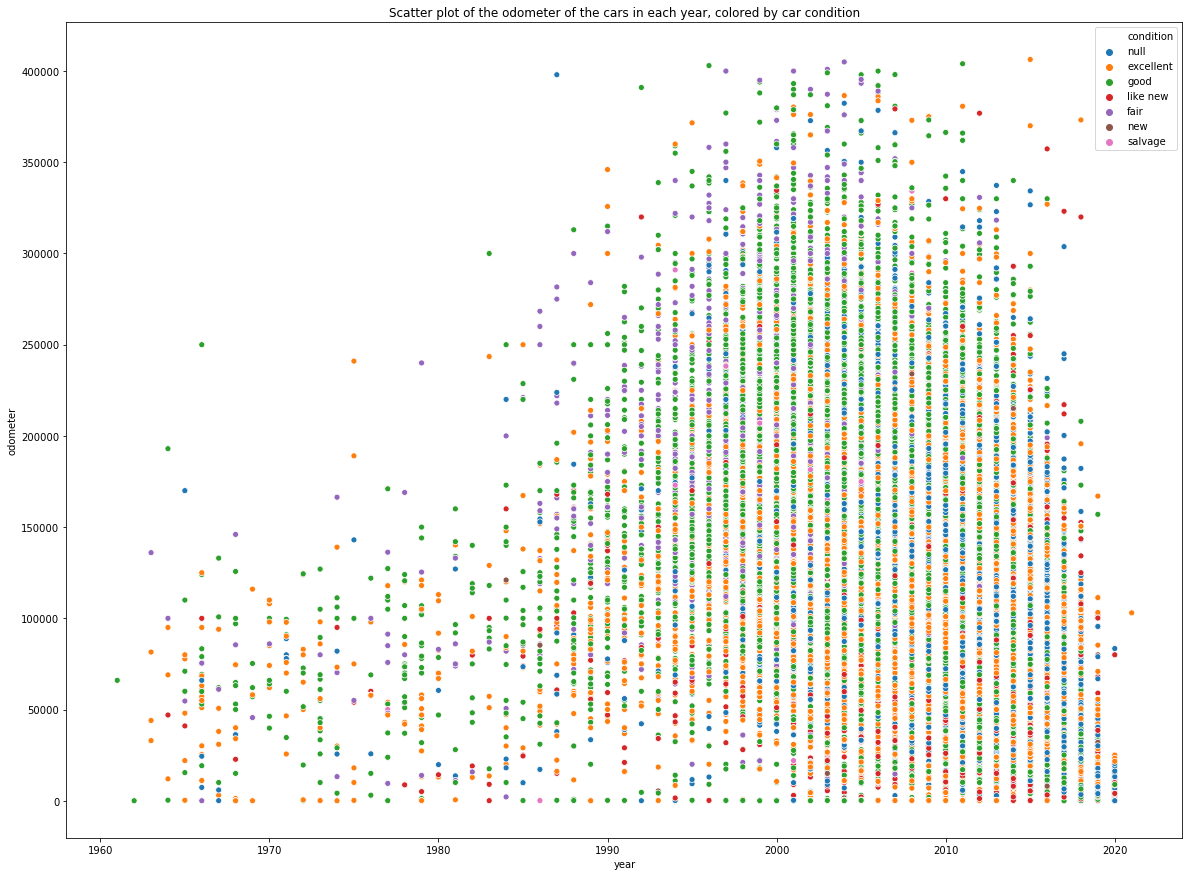

In [41]:
fig, ax = plt.subplots(figsize=(20,15))
ax.set_title('Scatter plot of the odometer of the cars in each year, colored by car condition')
sns.scatterplot(x='year', y='odometer', data=df, hue = 'condition')

**Higher odometer are more likely to be seeing in cars around 2005**. It is reasonable as **newer cars have not yet to accumulate high mileage**, while **older cars need to have lower mileage to be sold in a desent price in the used car market**. If a car has both high age and mileage, then the owner may directly sell the parts to the repair shop rather than selling it as a used car.

Also, we **can not see straight forward correlation between "condition" and "odometer" (or "year")**, which is a surprise. Myabe different people hold different views toward "condition" as it is quite subjective.

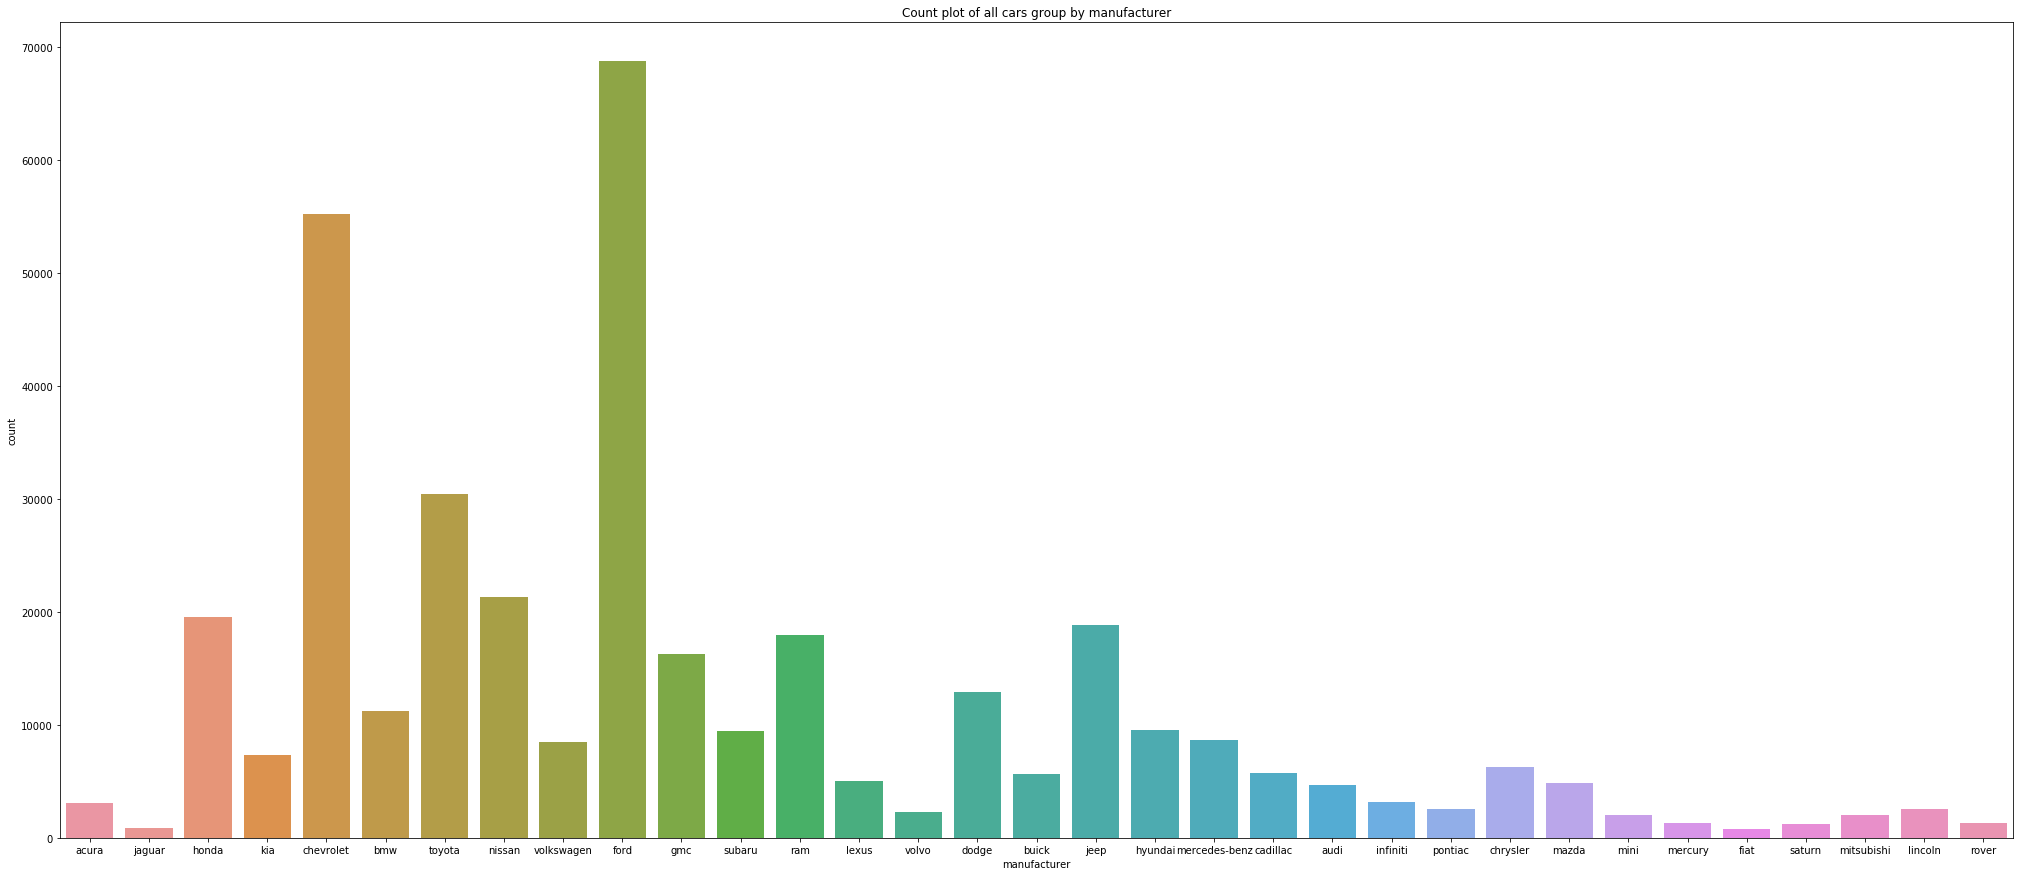

In [42]:
fig, ax = plt.subplots(figsize=(35,15))
ax.set_title('Count plot of all cars group by manufacturer')
sns.countplot(x='manufacturer', data=df_man)

From the table we see that the top five popular brands in the used car market are **Ford, Chevrolet, Toyota, Nissan and Jeep**.  

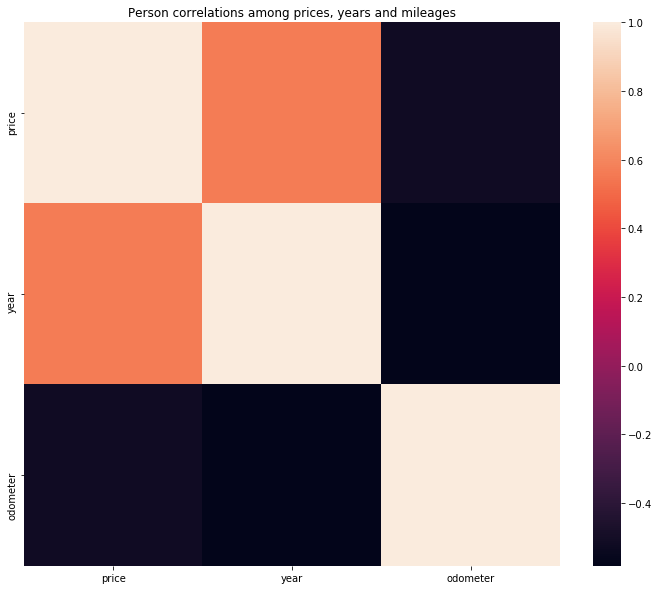

In [43]:
fig, ax = plt.subplots(figsize=(12,10))
ax.set_title('Person correlations among prices, years and mileages')
sns.heatmap(df.corr())

This is another way to see the **high correlations among years mileages and prices**

<a id="5"></a>
## 5. Model preparation
[Back to top](#head)

Before feeding those data to the machine learning models to predict prices, we still need to finish the following preparation tasks.

<a id="5.1"></a>
### 5.1 Encoding categorical features

We transform the string values in all categorical features into numeric values using **One Hot Encoding scheme**. Note that the "*drop_first*" parameter in "*get_dummies*" is to remove the first column for each feature to avoid the collinearity problem because of the correlations among each newly created columns.

In [44]:
cate_Columns = ['model', 'condition', 'cylinders', 'fuel', 'transmission', 'drive', 'type', 'paint_color']
for column in cate_Columns:
    column = pd.get_dummies(df[column],drop_first=True)
    df = pd.concat([df,column],axis=1)
df = df.drop(columns = cate_Columns)

In [45]:
df.head()

,price,year,odometer,1500 4x4,1500 big horn 4x4 gas,1500 crew cab,1500 crew cab laramie pickup,1500 crew cab slt pickup 4d,1500 laramie,1500 laramie 4x4 gas,...,brown,custom,green,grey,orange,purple,red,silver,white,yellow
3,3995,2004.0,212526.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,10995,2014.0,112383.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,3995,2007.0,185123.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,7995,2008.0,162214.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
16,12995,2009.0,146353.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a id="5.2"></a>
### 5.2 Normalization

We also need to **normalize the values** in the numerical features ("year" and "odometer"), as they do not have the same scale as the other newly created columns.

In [46]:
std_scaler = StandardScaler()

for column in ['year', 'odometer']:
    df[column] = std_scaler.fit_transform(df[column].values.reshape(-1,1))

In [47]:
df.head()

,price,year,odometer,1500 4x4,1500 big horn 4x4 gas,1500 crew cab,1500 crew cab laramie pickup,1500 crew cab slt pickup 4d,1500 laramie,1500 laramie 4x4 gas,...,brown,custom,green,grey,orange,purple,red,silver,white,yellow
3,3995,-1.240466,1.806069,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,10995,0.534831,0.132982,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,3995,-0.707877,1.348247,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,7995,-0.530347,0.965507,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
16,12995,-0.352817,0.700518,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a id="5.3"></a>
### 5.3 Split training and testing set

We set **70%** of the data to be the training set, leaving the remaining for testing.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('price',axis=1), 
                                                    df['price'], test_size=0.30, 
                                                    random_state=100)

<a id="6"></a>
## 6. Models and tuning
[Back to top](#head)

In this section, we are going to create and train several machine learning models to see their performance in this used car dataset for price prediction.

As it is a regression problem, we use **R2 score** and **root mean squared error** as the way to evaluate our models.

In [49]:
model_score = pd.DataFrame(columns=('r2', 'rmse'))

<a id="6.1"></a>
### 6.1 Linear Regression

In Scikit Learn, ***LinearRegression()*** is using **Ordinary Least Squares** to calculate the coefficients in the linear regression model, without the "learning" process through gradient descent.

In [50]:
lrmodel = LinearRegression()
lrmodel.fit(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
lr_predict = lrmodel.predict(X_test)

lr_r2 = metrics.r2_score(y_test, lr_predict)
lr_rmse = math.sqrt(metrics.mean_squared_error(y_test, lr_predict))

model_score = model_score.append(pd.DataFrame({'r2':[lr_r2], 'rmse':[lr_rmse]}, index = ['Linear Regression']))

print('For the linear regressor, the root mean square error for the testing set is:', lr_rmse)
print('The r2 score for the testing set is:', lr_r2)

fig, ax = plt.subplots(figsize=(20,15))
ax.set_title('Comparison between predicted prices and actual prices in testing set, linear regrssion')
plt.scatter(y_test, lr_predict)

We can see that linear regression model does not perform well in the dataset. To show whether it is overfitting, we calculate the score for the **training set**:

In [ ]:
lr_predict_train = lrmodel.predict(X_train)

lr_r2_train = metrics.r2_score(y_train, lr_predict_train)
lr_rmse_train = math.sqrt(metrics.mean_squared_error(y_train, lr_predict_train))

print('For the linear regressor, the root mean square error for the training set is:', lr_rmse_train)
print('The r2 score for the testing set is:', lr_r2_train)

fig, ax = plt.subplots(figsize=(20,15))
ax.set_title('Comparison between predicted prices and actual prices in training set, linear regrssion')
plt.scatter(y_train, lr_predict_train)

With similar **rmse** and **r2 score**, it seems that overfitting is not the probelm.

<a id="6.2"></a>
### 6.2 Lasso Regression

Lasso Regression is a linear regression model with **L1 regularization** factor to eliminate the errors caused by the collinearity problem and overfitting. We choose **12 regularization coefficents** and choose the best via **cross validation** method.

Although we see from above that the poor performance of the linear model is **not caused by overfitting**, we still decide to give Lasso a try.

In [ ]:
alphas = np.logspace(-4,4,12)
lasso = LassoCV(max_iter=10**6, alphas=alphas)
lasso.fit(X_train, y_train)

In [ ]:
lasso_predict = lasso.predict(X_test)

lasso_r2 = metrics.r2_score(y_test, lasso_predict)
lasso_rmse = math.sqrt(metrics.mean_squared_error(y_test, lasso_predict))

model_score = model_score.append(pd.DataFrame({'r2':[lasso_r2], 'rmse':[lasso_rmse]}, index = ['Lasso Regression']))

print('For the Lasso linear regressor, the root mean square error for the testing set is:', lasso_rmse)
print('The r2 score for the testing set is:', lasso_r2)

fig, ax = plt.subplots(figsize=(20,15))
ax.set_title('Comparison between predicted prices and actual prices in testing set, Lasso regrssion')
plt.scatter(y_test, lasso_predict)

Within expectation, the result is very close to the previous linear regression model.

With **r2 = 0.801, it seems like the best a linear model can do**, unless we do some deeper processing with the dataset itself.

<a id="6.3"></a>
### 6.3 MLP (Fully Connected Neuron Network)
Here we train a fully connected neuron network for regression using Keras.  

To change the model from solving classification problem to regression problem, we first change the output layer to be a single cell. Then we change the loss function from cross-entropy to be **MSE**. 

In [55]:
X_train.shape

(105358, 708)

In [53]:
X_test.shape

(45154, 708)

In [57]:
callback = callbacks.EarlyStopping(monitor='loss', patience=3)
nn_model = Sequential()
nn_model.add(Dense(input_dim = X_train.shape[1], units = 2000, activation = 'relu'))
#nn_model.add(Dropout(0.3))
nn_model.add(Dense(units = 1000, activation = 'relu'))
nn_model.add(Dense(units=1, activation = 'relu'))
nn_model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mae', 'mse'])

In [ ]:
nn_model.fit(X_train, y_train, batch_size=5000, epochs=800, callbacks=[callback])

Train on 105358 samples
Epoch 1/800
105358/105358 [==============================] - 2s 17us/sample - loss: 248623173.6836 - mae: 13280.4121 - mse: 248623168.0000
Epoch 2/800
105358/105358 [==============================] - 1s 7us/sample - loss: 231789583.6595 - mae: 12670.2236 - mse: 231789584.0000
Epoch 3/800
105358/105358 [==============================] - 1s 7us/sample - loss: 168205896.8260 - mae: 10123.8408 - mse: 168205888.0000
Epoch 4/800
105358/105358 [==============================] - 1s 7us/sample - loss: 77993141.3602 - mae: 6405.0005 - mse: 77993144.0000
Epoch 5/800
105358/105358 [==============================] - 1s 7us/sample - loss: 46246779.5705 - mae: 5402.2754 - mse: 46246776.0000
Epoch 6/800
105358/105358 [==============================] - 1s 7us/sample - loss: 34205586.2052 - mae: 4374.7783 - mse: 34205588.0000
Epoch 7/800
105358/105358 [==============================] - 1s 7us/sample - loss: 27568658.1981 - mae: 3851.4575 - mse: 27568658.0000
Epoch 8/800
105358/10

105358/105358 [==============================] - 1s 7us/sample - loss: 8667468.6113 - mae: 1968.6206 - mse: 8667470.0000
Epoch 62/800
105358/105358 [==============================] - 1s 7us/sample - loss: 8652684.2924 - mae: 1968.1289 - mse: 8652685.0000
Epoch 63/800
105358/105358 [==============================] - 1s 7us/sample - loss: 8634737.1438 - mae: 1965.5990 - mse: 8634738.0000
Epoch 64/800
105358/105358 [==============================] - 1s 7us/sample - loss: 8615840.9266 - mae: 1962.5754 - mse: 8615842.0000
Epoch 65/800
105358/105358 [==============================] - 1s 7us/sample - loss: 8598350.0807 - mae: 1960.4419 - mse: 8598350.0000
Epoch 66/800
105358/105358 [==============================] - 1s 7us/sample - loss: 8587849.3594 - mae: 1959.9744 - mse: 8587849.0000
Epoch 67/800
105358/105358 [==============================] - 1s 7us/sample - loss: 8570969.5439 - mae: 1959.0336 - mse: 8570970.0000
Epoch 68/800
105358/105358 [==============================] - 1s 7us/sample

105358/105358 [==============================] - 1s 8us/sample - loss: 7791815.9039 - mae: 1852.4366 - mse: 7791816.0000
Epoch 122/800
105358/105358 [==============================] - 1s 8us/sample - loss: 7775059.4587 - mae: 1850.4313 - mse: 7775059.0000
Epoch 123/800
105358/105358 [==============================] - 1s 8us/sample - loss: 7760770.1993 - mae: 1848.1404 - mse: 7760769.0000
Epoch 124/800
105358/105358 [==============================] - 1s 8us/sample - loss: 7744653.8044 - mae: 1844.2792 - mse: 7744653.5000
Epoch 125/800
105358/105358 [==============================] - 1s 8us/sample - loss: 7732226.9058 - mae: 1843.7323 - mse: 7732226.5000
Epoch 126/800
105358/105358 [==============================] - 1s 8us/sample - loss: 7716938.5153 - mae: 1840.1296 - mse: 7716938.5000
Epoch 127/800
105358/105358 [==============================] - 1s 8us/sample - loss: 7703204.2898 - mae: 1839.7350 - mse: 7703205.0000
Epoch 128/800
105358/105358 [==============================] - 1s 8us

105358/105358 [==============================] - 1s 11us/sample - loss: 7041046.0610 - mae: 1747.3263 - mse: 7041046.5000
Epoch 182/800
105358/105358 [==============================] - 1s 11us/sample - loss: 7026845.2733 - mae: 1746.3047 - mse: 7026845.5000
Epoch 183/800
105358/105358 [==============================] - 1s 11us/sample - loss: 7017916.6812 - mae: 1744.6357 - mse: 7017917.5000
Epoch 184/800
105358/105358 [==============================] - 1s 9us/sample - loss: 7009139.8209 - mae: 1743.5883 - mse: 7009140.0000
Epoch 185/800
105358/105358 [==============================] - 1s 9us/sample - loss: 6997290.5233 - mae: 1742.3251 - mse: 6997291.0000
Epoch 186/800
105358/105358 [==============================] - 1s 9us/sample - loss: 6984710.1398 - mae: 1742.1272 - mse: 6984710.0000
Epoch 187/800
105358/105358 [==============================] - 1s 9us/sample - loss: 6978881.1955 - mae: 1740.9878 - mse: 6978881.0000
Epoch 188/800
105358/105358 [==============================] - 1s 

105358/105358 [==============================] - 6s 53us/sample - loss: 6203427.0853 - mae: 1631.8563 - mse: 6203427.5000
Epoch 242/800
105358/105358 [==============================] - 5s 49us/sample - loss: 6185569.1333 - mae: 1628.0565 - mse: 6185569.0000
Epoch 243/800
 85000/105358 [=======================>......] - ETA: 1s - loss: 6184449.1765 - mae: 1630.1376 - mse: 6184449.5000

In [ ]:
nn_predict = nn_model.predict(X_test)

nn_rmse = math.sqrt(metrics.mean_squared_error(y_test, nn_predict))
nn_r2 = metrics.r2_score(y_test, nn_predict)

model_score = model_score.append(pd.DataFrame({'r2':[nn_r2], 'rmse':[nn_rmse]}, index = ['MLP']))

print('For the MLP model, the root mean square error for the testing set is:', nn_rmse)
print('The r2 score for the testing set is:', nn_r2)

fig, ax = plt.subplots(figsize=(20,15))
ax.set_title('Comparison between predicted prices and actual prices in testing set, MLP')
plt.scatter(y_test, nn_predict)

In [ ]:
nn_model.save("nn0.917")

With **r2 = 0.915** and **rmse = 2476** on the training set, this MLP regressor is the best model for now.

<a id="6.4"></a>
### 6.4 K-Nearest Neighbor

Sometimes KNN can achieve high accuracy, with the cost of time. As it is a type of "lazy study" model, the predicting time is very long even if the training is done.

We use ***GridSearchCV()*** to find the **best number of neighbors** via cross validation.

In [ ]:
knnReg = KNeighborsRegressor()

param_grid = [
     {
         'weights':['uniform'],
         'n_neighbors':[i for i in range(1,7)]
     }]

grid_search_knn = GridSearchCV(knnReg, param_grid,n_jobs=-1,verbose=2)
grid_search_knn.fit(X_train, y_train)

In [ ]:
knn_best = grid_search_knn.best_estimator_
knn_best

**The best number of neighbors for our knn model is 4**.

In [ ]:
knn_predict = knn_best.predict(X_test)

knn_r2 = metrics.r2_score(y_test, knn_predict)
knn_rmse = math.sqrt(metrics.mean_squared_error(y_test, knn_predict))

model_score = model_score.append(pd.DataFrame({'r2':[knn_r2], 'rmse':[knn_rmse]}, index = ['K - Nearest Neighbor']))

print('For the K-NN regressor, the root mean square error for the testing set is:', knn_rmse)
print('The r2 score for the testing set is:', knn_r2)
fig, ax = plt.subplots(figsize=(20,15))
plt.scatter(y_test, knn_predict)

We see that KNN model does achive a pretty high accuracy.

<a id="6.5"></a>
### 6.5 Decision Tree

In the decision tree model, we did not set the maximal depth or leaf nodes.

In [ ]:
dt_model = DecisionTreeRegressor(random_state=0)
dt_model.fit(X_train, y_train)

In [ ]:
dt_predict = dt_model.predict(X_test)

dt_r2 = metrics.r2_score(y_test, dt_predict)
dt_rmse = math.sqrt(metrics.mean_squared_error(y_test, dt_predict))

model_score = model_score.append(pd.DataFrame({'r2':[dt_r2], 'rmse':[dt_rmse]}, index = ['Decision Tree']))

print('For the decision tree regressor, the root mean square error for the testing set is:', dt_rmse)
print('The r2 score for the testing set is:', dt_r2)
fig, ax = plt.subplots(figsize=(20,15))
plt.scatter(y_test, dt_predict)

<a id="6.6"></a>
### 6.6 Random Forest

In [ ]:
ranF_model = RandomForestRegressor(max_depth=8, random_state=0)
ranF_model.fit(X_train, y_train)

In [ ]:
ranF_predict = ranF_model.predict(X_test)

ranF_r2 = metrics.r2_score(y_test, ranF_predict)
ranF_rmse = math.sqrt(metrics.mean_squared_error(y_test, ranF_predict))

model_score = model_score.append(pd.DataFrame({'r2':[ranF_r2], 'rmse':[ranF_rmse]}, index = ['Random Forest']))

print('For the random forest regressor, the root mean square error for the testing set is:', ranF_rmse)
print('The r2 score for the testing set is:', ranF_r2)
fig, ax = plt.subplots(figsize=(20,15))
plt.scatter(y_test, ranF_predict)

The random forest model does not give a good performance. It is even worse than the decision tree. Maybe the tree is not deep enough.

<a id="6.7"></a>
### 6.7 Support Vector Machine

We tried two different kernel for the support vector machine, **Gaussian** and **linear**.

In [ ]:
svr_model = SVR(C = 1, epsilon = 0.2, kernel = 'rbf', max_iter=10000)
svr_model.fit(X_train, y_train)

In [ ]:
svr_predict = svr_model.predict(X_test)

svr_r2 = metrics.r2_score(y_test, svr_predict)
svr_rmse = math.sqrt(metrics.mean_squared_error(y_test, svr_predict))

model_score = model_score.append(pd.DataFrame({'r2':[svr_r2], 'rmse':[svr_rmse]}, index = ['SVM_gaus']))

print('For the support vector regressor with gaussian kernel, the root mean square error for the testing set is:', svr_rmse)
print('The r2 score for the testing set is:', svr_r2)
fig, ax = plt.subplots(figsize=(20,15))
plt.scatter(y_test, svr_predict)

In [ ]:
svr_model2 = SVR(C = 1, epsilon = 0.2, kernel = 'linear', max_iter=10000)
svr_model2.fit(X_train, y_train)
svr_predict2 = svr_model2.predict(X_test)

svr2_r2 = metrics.r2_score(y_test, svr_predict2)
svr2_rmse = math.sqrt(metrics.mean_squared_error(y_test, svr_predict2))

model_score = model_score.append(pd.DataFrame({'r2':[svr2_r2], 'rmse':[svr2_rmse]}, index = ['SVM_linear']))

print('For the support vector regressor with linear kernal, the root mean square error for the testing set is:', svr2_rmse)
print('The r2 score for the testing set is:', svr2_r2)
fig, ax = plt.subplots(figsize=(20,15))
plt.scatter(y_test, svr_predict2)

For both cases, the models are forced to stop with our maximal iteration setting, or they will run forever... As a result, they both perform badly.

<a id="6.8"></a>
### 6.8 Gradient Boosting Decision Tree
We use Scikit Learn build-in GBDT model with default setting.

In [ ]:
gb_model = GradientBoostingRegressor(random_state=0)
gb_model.fit(X_train, y_train)

In [ ]:
gb_predict = gb_model.predict(X_test)

gb_r2 = metrics.r2_score(y_test, gb_predict)
gb_rmse = math.sqrt(metrics.mean_squared_error(y_test, gb_predict))

model_score = model_score.append(pd.DataFrame({'r2':[gb_r2], 'rmse':[gb_rmse]}, index = ['GBDT']))

print('For the gradient boosting regressor, the root mean square error for the testing set is:', gb_rmse)
print('The r2 score for the testing set is:', gb_r2)
fig, ax = plt.subplots(figsize=(20,15))
plt.scatter(y_test, gb_predict)

<a id="6.9"></a>
### 6.9 XGBoost

Finally, we adapt the advanced version of GBDT -- XGBoost into the dataset.

In [ ]:
xgb_model = XGBRegressor()

df_noDuplicate = df.loc[:,~df.columns.duplicated()]

X_train_nd, X_test_nd, y_train_nd, y_test_nd = train_test_split(df_noDuplicate.drop('price',axis=1), 
                                                    df['price'], test_size=0.30, 
                                                    random_state=141)


xgb_model.fit(X_train_nd, y_train_nd)

In [ ]:
xgb_predict = xgb_model.predict(X_test_nd)

xgb_r2 = metrics.r2_score(y_test_nd, xgb_predict)
xgb_rmse = math.sqrt(metrics.mean_squared_error(y_test_nd, xgb_predict))

model_score = model_score.append(pd.DataFrame({'r2':[xgb_r2], 'rmse':[xgb_rmse]}, index = ['XGBoost']))

print('For the XGboosting regressor, the root mean square error for the testing set is:', xgb_rmse)
print('The r2 score for the testing set is:', xgb_r2)
fig, ax = plt.subplots(figsize=(20,15))
plt.scatter(y_test_nd, xgb_predict)

XGBoost performs pretty well, just behind neuron network.

<a id="7"></a>
## 7. Evaluate and conclude
[Back to top](#head)

In [ ]:
model_score.sort_values(by=['r2'], ascending=False)

In [ ]:
model_score = model_score1

From the dataframe above, we conclude that **the neuron network performs the best** in this dataset. But even so, the rmse is still around 2600, which is **pretty large compared to the actual prices**. 

There are many reason for this. For example, we did not play very much with the parameters in the models above, indicating the models **could do better with proper parameters**. Also, the dataset may **not be clean enough**. There are some particular values in the categorical features that are insufficent (e.g. there are **only six 12-cylinder cars** and **165 electric cars** in total). **Some columns are still correlated**. A simple example is that most Subaru models (in the "model") are also AWD (in the "drive"). But most importantly, according to the scatter plot between the predicted prices and real prices, **there are always some points that have very large differences between the two**. I think the future job to make these model better is to **output these outliers and analze the causes of this huge bias**.